In [ ]:
source('results_and_plotting.R')
library(RColorBrewer)
library(latex2exp)

location_figures = "../../figures/"

In [ ]:
M1_results = load_M1_results("variant")

# Figure 1: G

In [ ]:
key = "pan_data"
method = "variant"

options(repr.plot.width = 12, repr.plot.height = 5)

gamma_plot = plot_M1_results(M1_results, key, method, "selection", show_genes = FALSE)
legend = get_legend(gamma_plot + theme(legend.title = element_blank(), legend.text = element_text(size=14)))#theme(legend.title = element_text(size=16), legend.text = element_text(size=14)))
gamma_plot = gamma_plot + theme(legend.position='none') + 
                # scale_y_continuous(labels=function(x){x/1e6}, limits=c(0,5e6), breaks=c(0,0.25,0.5,1,1.5,2)*1e6) +
                scale_y_log10(labels=function(x){x/1e6}, limits=c(NA,8e6)) +
                ylab(TeX(r'(Scaled selection coefficient $(\times 10^{6})$)'))
                # ylab(TeX(r'(Scaled selection coefficient)'))
flux_plot = plot_M1_results(M1_results, key, method, "fixation",show_freq_legend = FALSE) + 
                theme(axis.ticks.y=element_line(), axis.title.y = element_blank()) + 
                scale_y_continuous(limits = c(0, NA)) +
                ylab(TeX(r'(Fixation rate ($\propto$mutation prevalence))'))
mu_plot = plot_M1_results(M1_results, key, method, "mutation",show_freq_legend = FALSE, show_genes = FALSE) + 
            scale_y_continuous(labels=function(x){x/1e-6}, limits=c(0,NA), breaks=seq(0,2.1e-6,0.3e-6)) + 
            ylab(TeX(r'(Mutation rate $(\times 10^{-6})$)'))


p = plot_grid(flux_plot, mu_plot, gamma_plot, ncol=3, rel_widths=c(1.25,1,1))
p = plot_grid(p, legend, ncol=1, rel_heights=c(1,0.1))
p

In [ ]:
M1_results %>% filter(key=="pan_data") %>% arrange(desc(freq))

In [ ]:
M1_results %>% filter(key=="pan_data") %>% arrange(mu)

In [ ]:
cor.test(M1_results[key=="pan_data", log10(gamma_mle)], M1_results[key=="pan_data", log10(freq)])

In [ ]:
options(repr.plot.width = 5.5, repr.plot.height = 7)
mod <- lm(log10(gamma_mle)~log10(freq),data=M1_results[key=="pan_data"])

p <- ggplot(M1_results[key=="pan_data"], aes(x=freq, y=gamma_mle)) + 
    geom_smooth(method=lm, formula=y~x, alpha=0.2, linewidth=2) +
    geom_point(size=3) +#, shape=21, stroke=3) +
    ggrepel::geom_text_repel(data = M1_results[key=="pan_data"][order(-abs(mod$residuals))[1:5]], aes(label=gene), size=8) +
    ggrepel::geom_text_repel(data=M1_results[key=="pan_data" & gene =="BRCA2"], aes(label=gene), size=8, nudge_x=-0.1, nudge_y=0.1) +
    scale_y_log10(breaks=scales::log_breaks(), labels=function(x){x/1e6}) +# scientific_expr) +
    scale_x_log10() +
    annotation_logticks(base=10, sides="bl") +
    labs(x="Mutation prevalence", y=TeX(r'(Scaled selection coefficient $(\times 10^{6})$)')) +
    theme_bw() + 
    theme(axis.text = element_text(size=24), axis.title = element_text(size=28),
        panel.border = element_blank(), axis.line = element_line(linewidth=0.4),
        panel.grid.minor = element_blank(), panel.grid.major = element_blank())
p

# Figure 2: GxE

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 4.25)
p = M1_results %>%
    filter(method == "variant") %>%
    filter(key %in% c("smoking_plus","nonsmoking_plus")) %>%
    pivot_wider(
                names_from = key,
                id_cols = gene,
                values_from = mu
            ) %>% {
    ggplot(data=.,aes(x=nonsmoking_plus,y=smoking_plus)) +
        geom_abline(slope=1,intercept=0,lty=2) +
        theme_classic() +
        labs(x=TeX(r'(Mutation rate in NS-LUAD $(\times 10^{-7})$)'),
             y=TeX(r'(Mutation rate in ES-LUAD $(\times 10^{-7})$)'))+
        scale_y_continuous(labels=function(x){x/1e-7}, breaks=c(1,5,10,15,20,37,40)*1e-7, limits=c(1e-8,39e-7)) + 
        scale_x_continuous(labels=function(x){x/1e-7}, breaks=c(0.1, seq(0.5,3,0.5))*1e-7, limits=c(1e-8,NA), expand=c(0,5e-9)) +
        scale_y_break(breaks=c(18,37)*1e-7) +
        # scale_y_continuous(labels=function(x){x/1e-7}, breaks=c(1,5,10,15,20,35,40)*1e-7, limits=c(0,15*1e-7)) + 
        geom_text_repel(aes(label=gene), fontface="italic",point.padding = 3) +
        # geom_text(data=.%>%filter(gene=="ALK"), aes(label=gene,x=nonsmoking_plus,y=smoking_plus), fontface="italic") +
        # geom_text(aes(label=gene), fontface="italic", nudge_y = 9e-8) + 
        geom_rect(xmin=2.3e-7,xmax=2.5e-7,ymin=17.6e-7,ymax=19e-7, fill="white") +
        geom_rect(xmin=0,xmax=3e-7,ymin=19e-7,ymax=39e-7, fill="white") +
        geom_text(data=.%>%filter(gene=="ALK"), aes(label=gene,x=nonsmoking_plus,y=smoking_plus), fontface="italic", nudge_x=-1.5e-8) +
        geom_point(size=4, color="#7373d2") +
        theme(axis.title = element_text(size=18),
              axis.text = element_text(size=16),
              axis.line.y.right = element_blank(), axis.text.y.right = element_blank(), axis.ticks.y.right = element_blank(),
              axis.line.x.top = element_blank(), axis.text.x.top = element_blank(), axis.ticks.x.top = element_blank())
    }
p

In [ ]:
options(repr.plot.width=10, repr.plot.height=5.6)
p = plot_GxE_results(M1_results,"variant",ratio_plot = F) + 
    labs(x="Mutated gene",title="", y=TeX(r'(Scaled selection coefficient $(\times 10^{6})$)')) +
    scale_y_continuous(trans = scales::sqrt_trans(), labels = function(x){x/1e6}, breaks=c(0.01,0.1,0.25,0.5,1,1.5,2,3,4)*1e6) +
     theme(legend.position = c(0.85,0.9), axis.title.x=element_blank(), axis.text.x = element_text(color="black"))
p

## Analysis for results text

In [ ]:
M1_results %>% filter(key %in% c("smoking_plus","nonsmoking_plus")) %>%
    pivot_wider(
        names_from = key,
        id_cols = gene,
        values_from = mu
    ) %>%
    mutate(per_inc = round((smoking_plus-nonsmoking_plus)/nonsmoking_plus * 100,1)) %>%
    arrange(desc(per_inc))

In [ ]:
M1_results %>% filter(key %in% c("smoking_plus","nonsmoking_plus")) %>%
    pivot_wider(
        names_from = key,
        id_cols = gene,
        values_from = gamma_mle
    ) %>%
    mutate(
        ns_over_s = nonsmoking_plus/smoking_plus,
        s_over_ns = 1/ns_over_s,
        percent_diff = round(100*(smoking_plus - nonsmoking_plus)/nonsmoking_plus,2)) %>%
    # arrange(desc(abs(percent_diff)))
    # arrange(desc(nonsmoking_plus))
    arrange(desc(ns_over_s))

## Supplementary Figure 1

In [ ]:
M1_all_results = load_M1_all_results("variant")

In [ ]:
options(repr.plot.width = 8,repr.plot.height = 8)

alpha_palette = c("TRUE"=0.8,"FALSE"=0.025)
color_palette = c('1'='blue','2'='red')
fill_palette = c("TRUE"="yellow","FALSE"="#ffffff")

p = M1_all_results %>%
  filter(gamma_ci_low >= 1) %>%
  pivot_wider(names_from = key, values_from = c(gamma_mle, gamma_ci_low, gamma_ci_high), id_cols = gene) %>%
  mutate(selection_ratio = gamma_mle_nonsmoking_plus/gamma_mle_smoking_plus,
          signif_diff = (gamma_ci_low_nonsmoking_plus > gamma_ci_high_smoking_plus | gamma_ci_low_smoking_plus > gamma_ci_high_nonsmoking_plus)
          ) %>% {
              ggplot(.,aes(x=gamma_mle_nonsmoking_plus,y=gamma_mle_smoking_plus, alpha=signif_diff)) +
              geom_errorbarh(aes(xmin=gamma_ci_low_nonsmoking_plus,xmax=gamma_ci_high_nonsmoking_plus),
                              height=0, linewidth=0.3) + 
              geom_errorbar(aes(ymin=gamma_ci_low_smoking_plus,ymax=gamma_ci_high_smoking_plus),
                              width=0, linewidth=0.3) + 
              geom_point(aes(fill=signif_diff),shape=21, size=2) + 
              geom_abline(slope = 1, intercept = 0, lty=2) +
              #geom_point(aes(x=1,y=1),color="white") + 
              ggrepel::geom_text_repel(data = . %>% filter(signif_diff) %>% filter(selection_ratio<1 | selection_ratio>5 | (selection_ratio>1 & gamma_mle_nonsmoking_plus>3e5)),
                  
                  #(abs(log10(selection_ratio)) > log10(8) | gamma_mle_smoking_plus > 1e6 | gamma_mle_nonsmoking_plus > 5e6 ), signif_diff),
                              aes(label=gene, color = ifelse(selection_ratio>1,'1','2')),
                              alpha=1,
                              size=5,
                              max.overlaps = 100) + 
              scale_alpha_manual(values=alpha_palette) +
              scale_color_manual(values=color_palette) +
              scale_fill_manual(values=fill_palette) +
              scale_x_log10(labels=log_labels, limits=c(3e2,NA)) + scale_y_log10(labels=log_labels,limits=c(3e2,NA)) +
              annotation_logticks() +
              labs(x="Scaled selection coefficient in never-smoker LUAD",y="Scaled selection coefficient in ever-smoker LUAD", alpha = "Significant Difference") +
              theme_classic() + 
              theme(axis.title = element_text(size=18),
                      axis.text = element_text(size=16),
                      legend.position="none")
          }

p

In [ ]:
M1_all_results %>%
    filter(key %in% c("smoking_plus","nonsmoking_plus")) %>%
    pivot_wider(names_from = key, id_cols = gene, values_from = c(gamma_mle, gamma_ci_low, gamma_ci_high)) %>%
    mutate(signif = (gamma_ci_low_smoking_plus > gamma_ci_high_nonsmoking_plus | gamma_ci_low_nonsmoking_plus > gamma_ci_high_smoking_plus),
            ratio = gamma_mle_smoking_plus/gamma_mle_nonsmoking_plus) %>%
    filter(signif, ratio<1, gamma_mle_smoking_plus>0, gamma_mle_nonsmoking_plus>0) %>%
    arrange((ratio)) %>%
    select(gene, starts_with("gamma_mle"), ratio) %>%
    head(20)

# Figure 3: TP53 + RB1

In [ ]:
M1_results %>% filter(key %in% c("smoking_plus","nonsmoking_plus"), gene %in% c('TP53','RB1')) %>% select(gene, key, mu) 

In [ ]:
M2_results = load_M2_results("variant")
variant_M2_smoking_interaction_df = get_interaction_df(M2_results %>% filter(key == "smoking_plus", method=="variant"))
variant_M2_nonsmoking_interaction_df = get_interaction_df(M2_results %>% filter(key == "nonsmoking_plus", method=="variant"))

In [ ]:
variant_M2_smoking_interaction_df %>% filter(gene_set =="TP53_RB1")
variant_M2_nonsmoking_interaction_df %>% filter(gene_set =="TP53_RB1")

# Figure 4: GxG

## Panels A and B

In [123]:
source('results_and_plotting.R')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


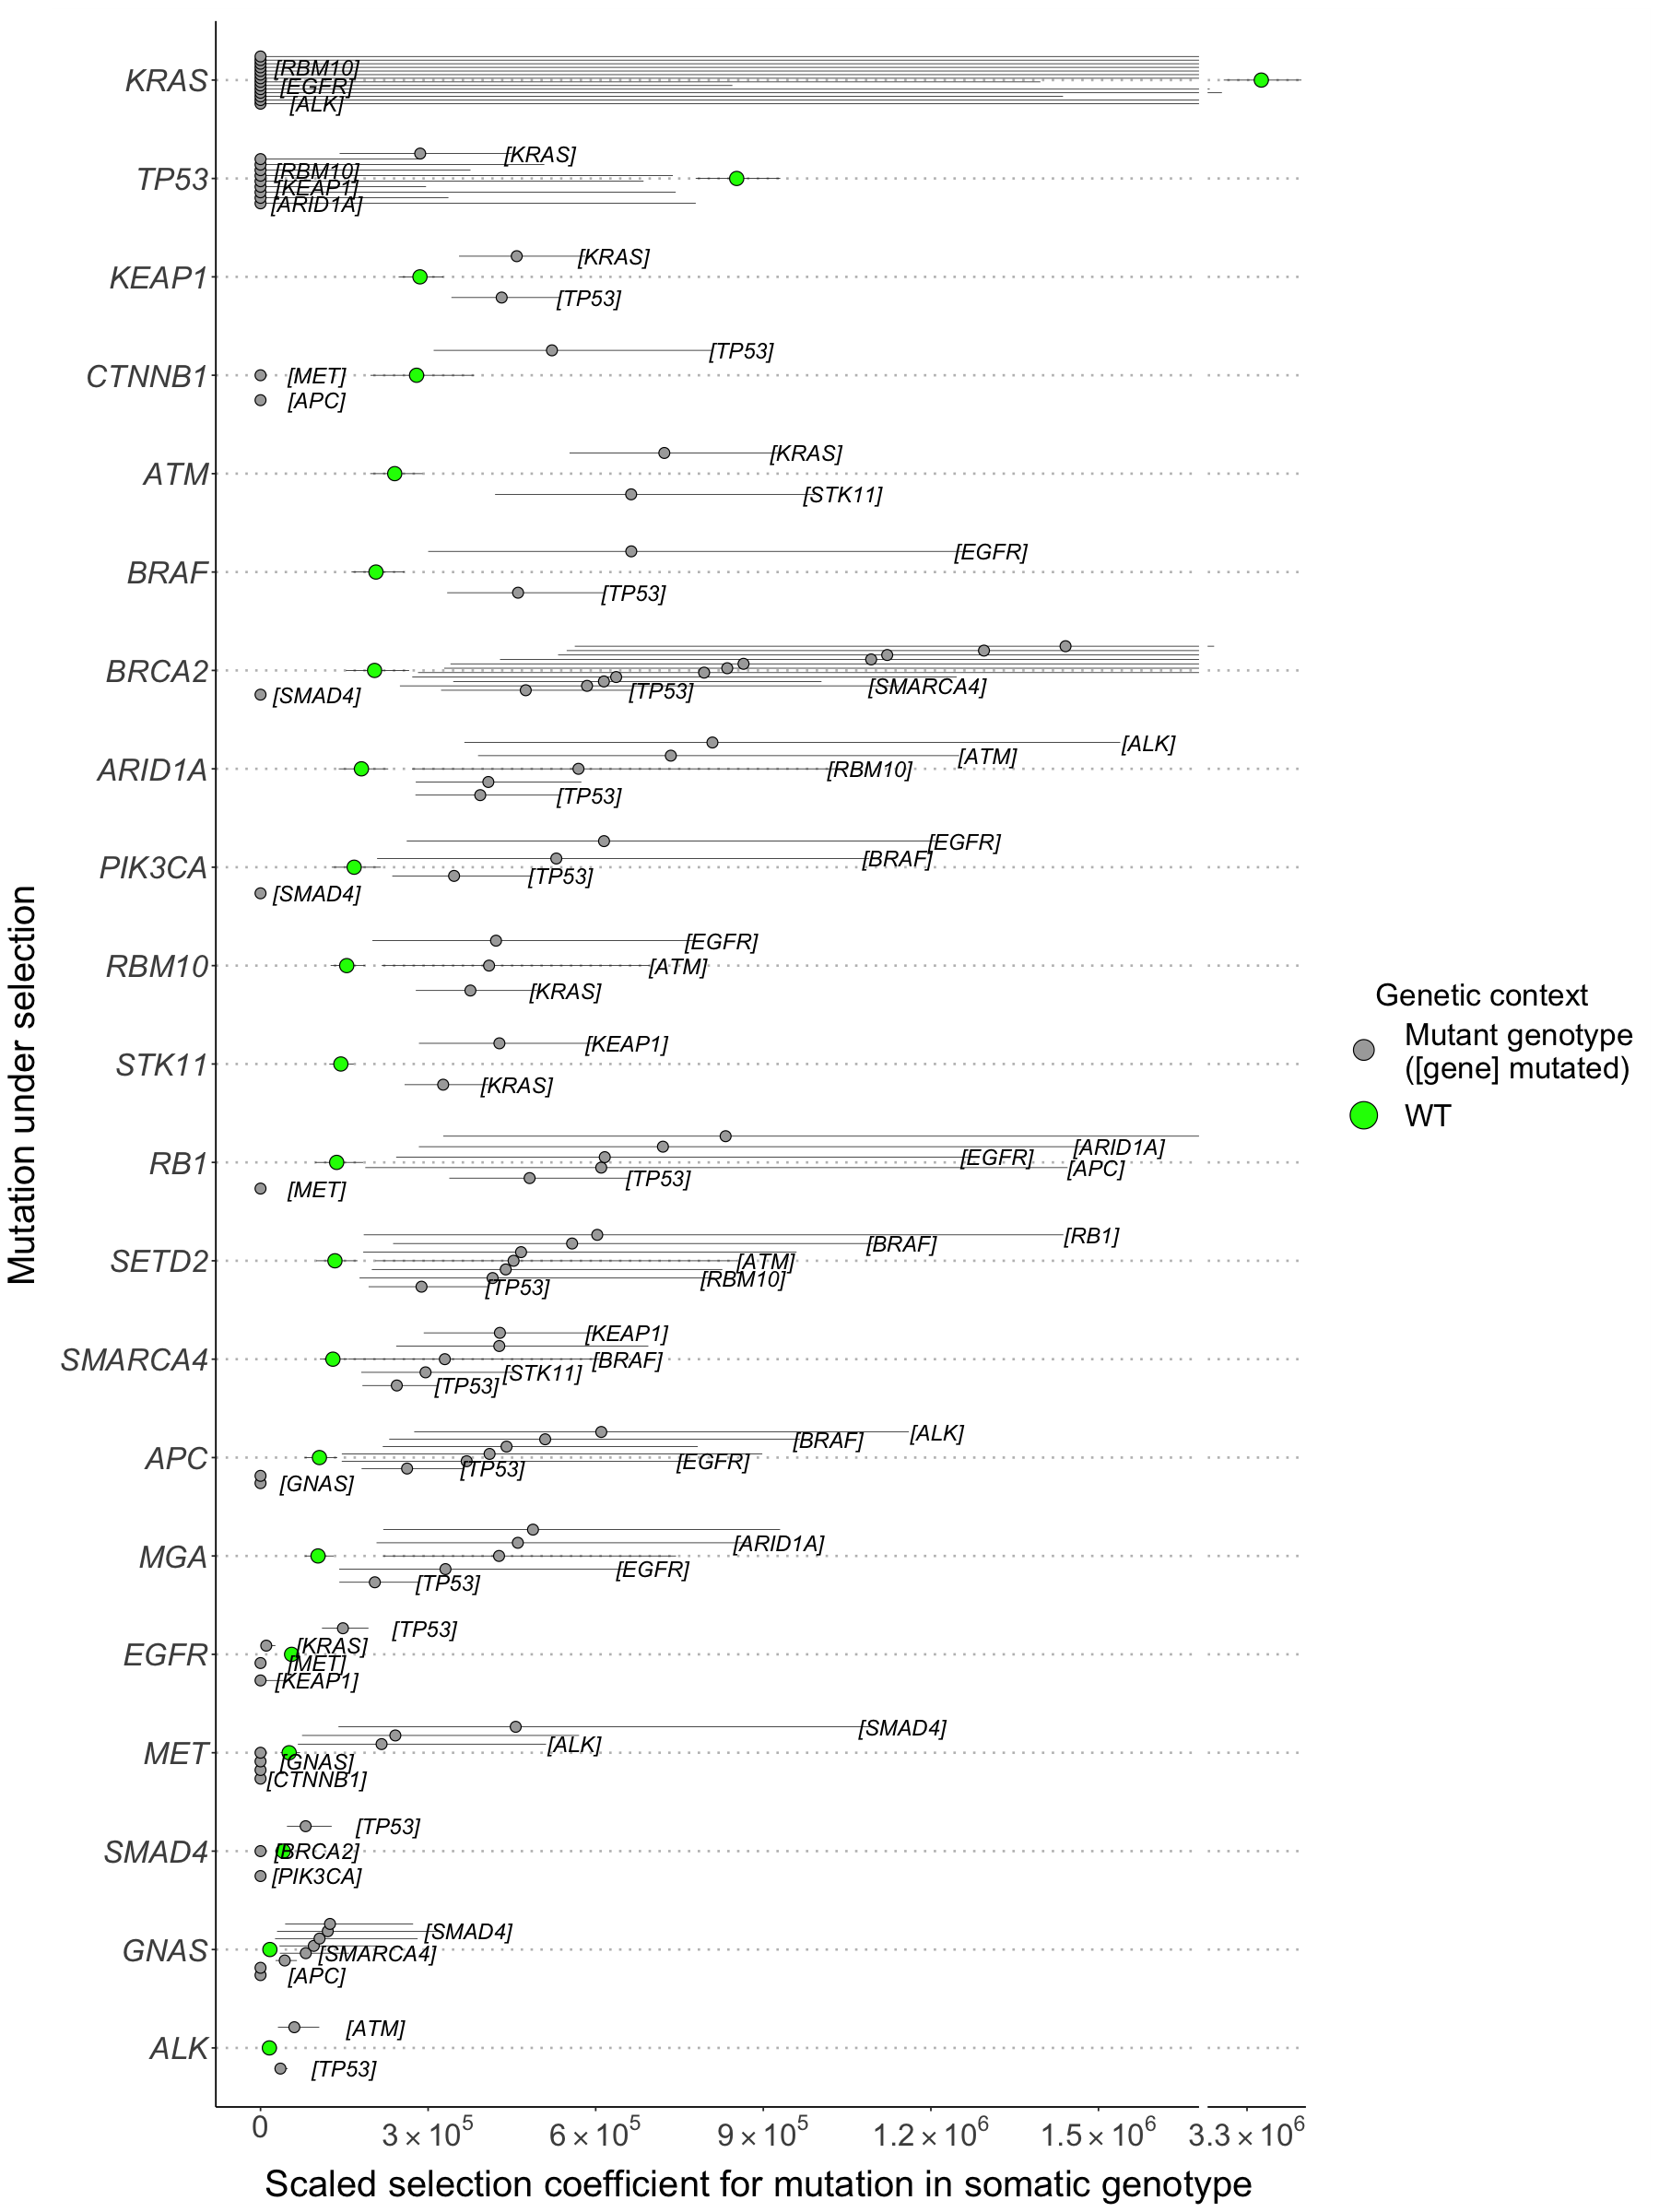

In [125]:
options(repr.plot.width = 15, repr.plot.height = 20)

ceiling = 1.6e6
p = plot_all_pairwise_epistatic_effects(variant_M2_smoking_interaction_df,
                                    M1_results %>% filter(key=="smoking_plus", method=="variant"),
                                    ceiling=NULL, low_gamma_label_adjustment = 1e5) + 
    scale_y_continuous(labels = scientific_expr, breaks = c(seq(0,ceiling-1,3e5),3.3e6)) + 
    ggbreak::scale_y_break(c(ceiling,3e6), scales=0.1) + 
    theme(axis.title.x = element_text(hjust=0.35),
            axis.text.x.top = element_blank(),
            axis.line.x.top = element_blank(),
            axis.ticks.x.top = element_blank())
p

In [126]:
ggsave(paste0(location_figures, 'GxG_smoker.png'),p,width = 15, height=20)

In [ ]:
genes_to_exclude <- setdiff(subset_genes, c("KRAS",variant_M2_nonsmoking_interaction_df %>% filter(signif, ratio>1) %>% pull(mutated_gene) %>% unique()))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


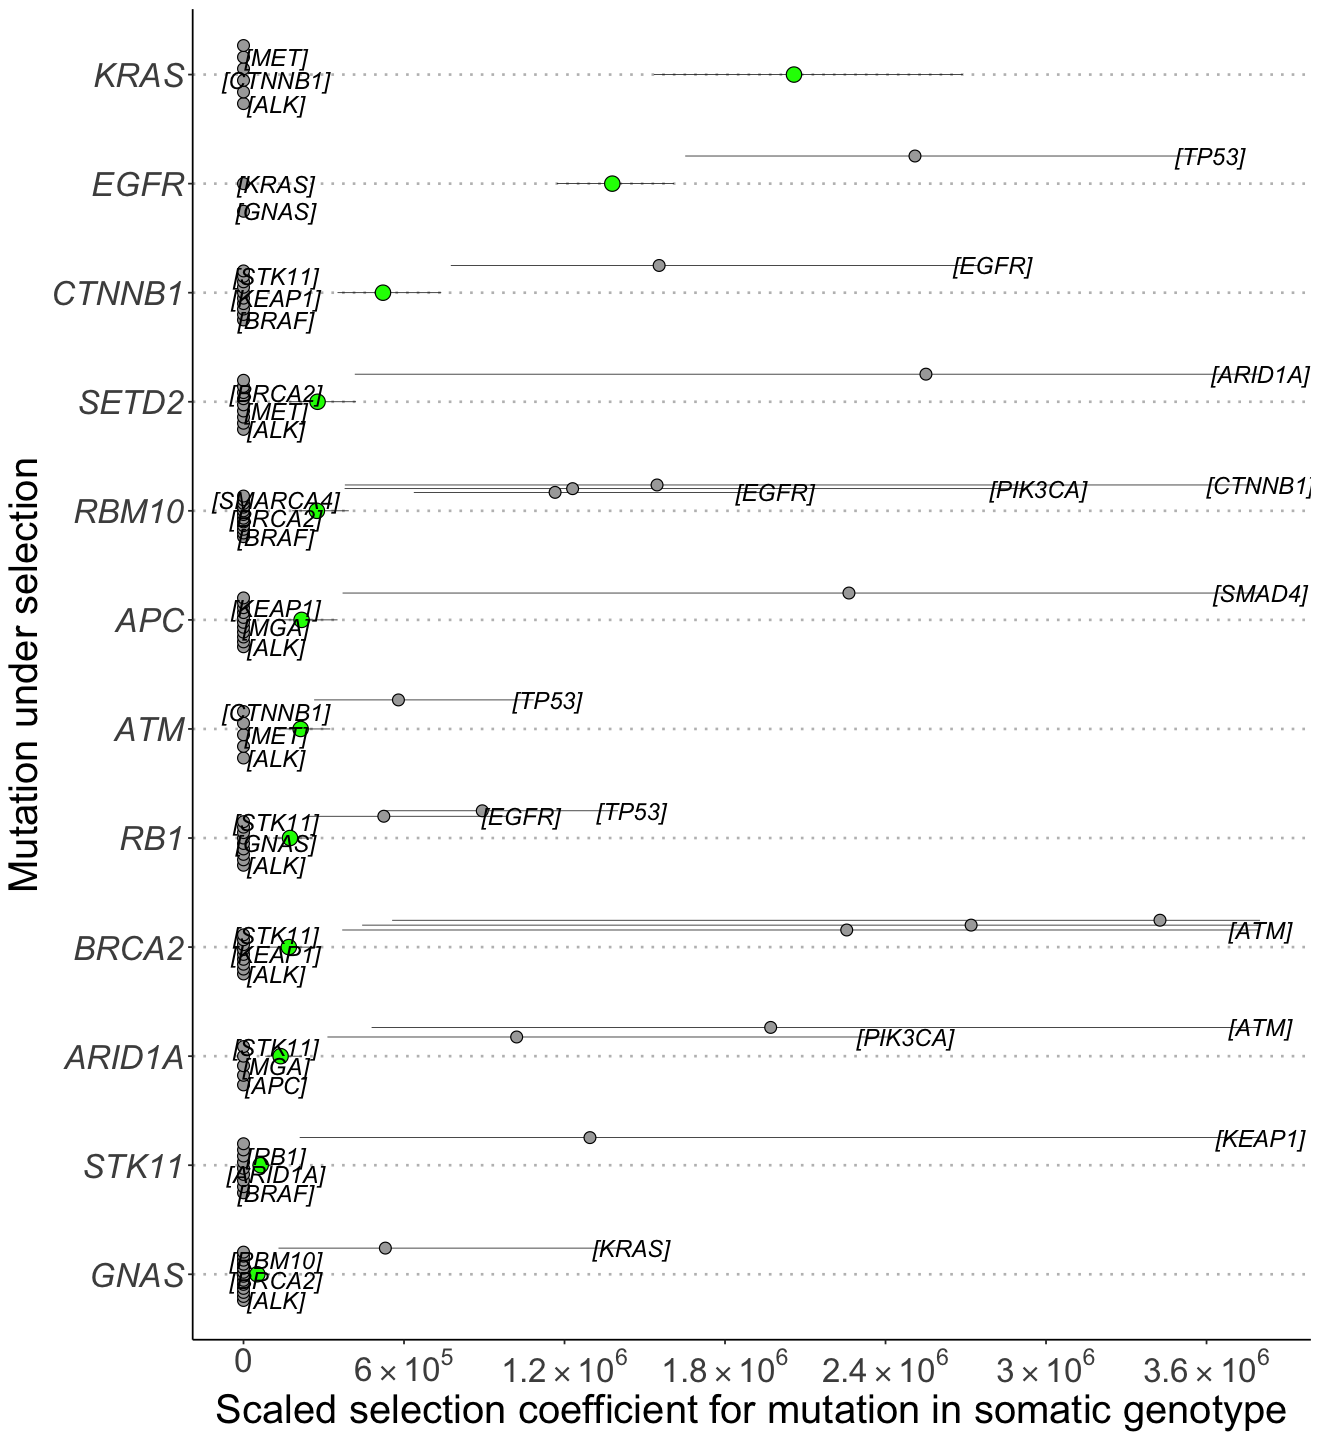

In [127]:
options(repr.plot.width = 11, repr.plot.height = 12)

ceiling = 3.8e6
p = plot_all_pairwise_epistatic_effects(variant_M2_nonsmoking_interaction_df %>% filter(!mutated_gene %in% genes_to_exclude),
                                    M1_results %>% filter(key=="nonsmoking_plus", method=="variant", !gene %in% genes_to_exclude),
                                    ceiling=ceiling) + 
    scale_y_continuous(labels = scientific_expr, breaks = seq(0,ceiling-1,6e5))
p = p + theme(legend.position="none")
p

In [128]:
ggsave(paste0(location_figures, 'GxG_nonsmoker.png'),p,width = 11, height=12)

## Analysis for results text

In [ ]:
ranked_smoking_genes = M1_results %>% filter(key=="smoking_plus") %>% arrange(desc(gamma_mle)) %>% pull(gene)
ranked_nonsmoking_genes = M1_results %>% filter(key=="nonsmoking_plus") %>% arrange(desc(gamma_mle)) %>% pull(gene)

oncogenes = c("KRAS", "BRAF", "EGFR", "CTNNB1", "PIK3CA", "MET", "GNAS", "ALK")
tsgs = c("TP53", "KEAP1", "ATM", "STK11", "BRCA2", "SETD2", "RBM10", "APC", "MGA", "RB1", "SMAD4")
chromatin_remodelers = c("SMARCA4", "ARID1A")

Epistatic patterns of strongly selected genes in ES-LUAD

In [ ]:
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT") %>%
    filter(mutated_gene %in% ranked_smoking_genes[1:9], ratio > 1) %>%
    arrange(ratio)
    # filter(epistatic_gt %in% c("TP53","KRAS"))

Epistatic patterns of chromatin remodeling genes and moderately strongly selected tumor suppressor genes

In [ ]:
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT") %>%
    filter(mutated_gene %in% c("BRCA2", "SETD2", "RBM10", "APC", "MGA", "RB1"),
            epistatic_gt %in% c("TP53","EGFR")) %>%
    count(mutated_gene) %>% arrange(n)

In [ ]:
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT") %>%
    filter(mutated_gene %in% c("BRCA2", "SETD2", "RBM10", "APC", "MGA", "RB1")) %>%
    #filter(mutated_gene %in% chromatin_remodelers) %>%
    arrange(ratio) %>%
    count(epistatic_gt) %>%
    arrange(desc(n))

Epistatic patterns of oncogenes

In [ ]:
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT") %>%
    filter(mutated_gene %in% oncogenes) %>% 
        group_by(ratio>1) %>% 
        count(epistatic_gt) %>%
        arrange(desc(n))
        # group_by(ratio<1) %>% 
        # count(epistatic_gt) %>%
        # arrange(desc(n))
        # filter(ratio>1) %>%
        # count(mutated_gene) %>% 
        # arrange(desc(n))

In [ ]:
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT") %>%
    filter(mutated_gene %in% oncogenes) %>% 
    arrange(mutated_gene) %>% 
    group_by(mutated_gene) %>%
    filter((all(ratio<1)|all(ratio>1)))

Median effect of synergistic epistasis

In [ ]:
print("Median effect of synergistic epistasis in ES-LUAD")
variant_M2_smoking_interaction_df %>% filter(signif, epistatic_gt != "WT", ratio>1) %>%
    pull(ratio) %>% summary

print("Median effect of synergistic epistasis in NS-LUAD")
variant_M2_nonsmoking_interaction_df %>% filter(signif, epistatic_gt != "WT", ratio>1) %>%
    pull(ratio) %>% summary

Correlation of strength of synergistic epistasis with ...

1) Strength of selection on prior mutation

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6)

tmp = variant_M2_smoking_interaction_df %>% filter(epistatic_gt != "WT", signif, ratio>1) %>%
    select(gene_set, epistatic_gt, ratio) %>% rename(mutated_gene = epistatic_gt) %>% mutate(epistatic_gt = "WT") %>%
    left_join(variant_M2_smoking_interaction_df %>% select(gene_set, epistatic_gt, mutated_gene, gamma_mle), 
                by=c("gene_set","epistatic_gt","mutated_gene"))

tmp %>%
    ggplot(aes(x=log(gamma_mle),y=ratio)) + 
        geom_point() +
        geom_smooth(method="lm", formula = y~log(x), alpha=0.5) + 
        labs(x="log(Selection coefficient) for prior mutation",y="Epistatic ratio") +
        theme_bw()

ratio_model = lm(ratio~log(gamma_mle), data=tmp)
summary(ratio_model)

In [ ]:
cor.test(tmp$gamma_mle,tmp$ratio)

2) Strength of selection on secondary mutation

In [ ]:
cor.test(
    variant_M2_smoking_interaction_df %>% filter(epistatic_gt == "WT", signif, ratio>1) %>% filter(ratio<20) %>% pull(gamma_mle),
    variant_M2_smoking_interaction_df %>% filter(epistatic_gt == "WT", signif, ratio>1) %>% filter(ratio<20) %>% pull(ratio)
)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
variant_M2_smoking_interaction_df %>% filter(epistatic_gt == "WT", signif, ratio>1) %>% 
    filter(ratio<20) %>%
    ggplot(aes(x=gamma_mle, y=ratio)) +
        geom_point() + theme_bw() + geom_smooth(method="lm", formula = y~x) + 
        geom_hline(yintercept = 3, linetype="dashed") + geom_hline(yintercept = 8, linetype="dashed") +
        labs(x="Baseline selection coefficient for affected mutation", y="Epistatic ratio") +
        theme_bw()
        
ratio_model = lm(ratio~gamma_mle, 
                data=variant_M2_smoking_interaction_df %>% filter(epistatic_gt == "WT", signif, ratio>1) %>% filter(ratio<20))
summary(ratio_model)

Antagonistic sign epistasis

In [ ]:
variant_M2_smoking_interaction_df %>% filter(epistatic_gt != "WT", gamma_ci_high<1, signif) %>% arrange(gene_set)
# variant_M2_smoking_interaction_df %>% filter(epistatic_gt != "WT", gamma_mle<1)

Antagonistic magnitude epistasis

In [ ]:
variant_M2_smoking_interaction_df %>% filter(epistatic_gt != "WT", gamma_mle>1, ratio<1)

Synergistic and antagonistic epistasis in NS-LUAD

In [ ]:
tmp = variant_M2_smoking_interaction_df %>% full_join(variant_M2_nonsmoking_interaction_df, by=c("tested_combo", "epistatic_gt"), suffix = c("_smoking", "_nonsmoking")) %>%
  filter(epistatic_gt != "WT") %>%
  select(tested_combo, ratio_smoking, ratio_nonsmoking, signif_smoking, signif_nonsmoking) %>%
  mutate(syn_smoking = ratio_smoking > 1, syn_nonsmoking = ratio_nonsmoking > 1) %>%
  select(-c(ratio_smoking, ratio_nonsmoking)) 

dcast(setDT(tmp), syn_smoking + signif_smoking ~ syn_nonsmoking + signif_nonsmoking)
dcast(setDT(tmp), syn_nonsmoking + signif_nonsmoking ~ syn_smoking + signif_smoking)

In [ ]:
dcast(setDT(tmp %>% filter(signif_nonsmoking, signif_smoking)), syn_nonsmoking ~ syn_smoking)

In [ ]:
tmp %>% filter(syn_smoking, signif_smoking, !syn_nonsmoking, signif_nonsmoking) %>% mutate(gene = str_split_i(tested_combo,"_",2)) %>% count(gene) %>% arrange(desc(n))

In [ ]:
tmp %>% filter(syn_smoking, signif_smoking, !syn_nonsmoking, signif_nonsmoking)# %>% mutate(gene = str_split_i(tested_combo,"_",2)) %>% count(gene) %>% arrange(desc(n))

In [ ]:
variant_M2_nonsmoking_interaction_df %>% filter(epistatic_gt != "WT", ratio>1, signif) %>% arrange(ratio) # %>% pull(ratio) %>% summary

Asymmetric epistasis

In [ ]:
variant_M2_smoking_interaction_df %>% filter(epistatic_gt != "WT", signif) %>%
  group_by(gene_set) %>% filter(n() == 2) %>%
  filter(!all(gamma_mle < 1))

In [ ]:
variant_M2_smoking_interaction_df %>% filter(gene_set == "KEAP1_STK11")

In [ ]:
variant_M2_smoking_interaction_df %>% filter(gene_set == "KRAS_KEAP1")

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


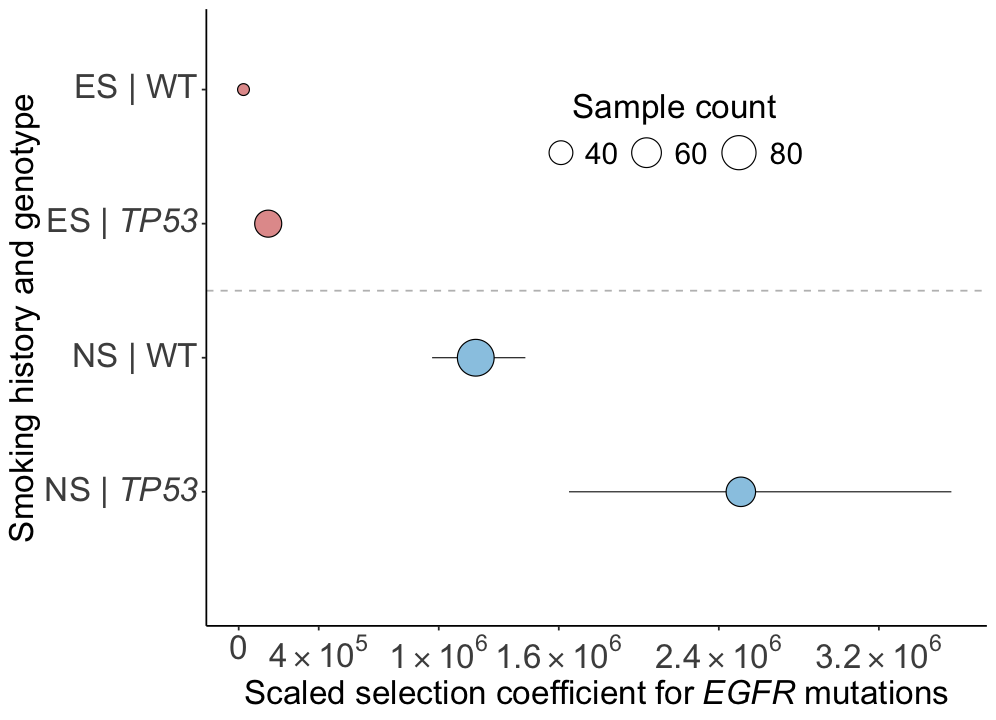

In [132]:
mod_plot_gge_interaction = function(mg, gt, smoking_df, nonsmoking_df){
    scale_factor<-1

    smoking_df %>% bind_rows(nonsmoking_df, .id="key") %>% filter(tested_combo == paste0(gt,"_",mg)) %>%
    mutate(key = ifelse(key==1, "Ever-smoker","Never-smoker")) %>%
    mutate(y_label = ifelse(epistatic_gt == "WT", "WT", "*TP53*"),
           y_label = ifelse(key == "Ever-smoker", paste("ES","|",y_label), paste("NS","|",y_label)),
           y_label = factor(y_label, levels = c("NS | *TP53*","NS | WT","ES | *TP53*","ES | WT"))) %>% {
        ggplot(.,aes(x=gamma_mle, y=y_label)) + 
            geom_errorbarh(aes(xmin=gamma_ci_low,xmax=gamma_ci_high),
                            height=0,linewidth=0.3) + 
            geom_point(aes(fill=key, size=to_count),
                            color="black",
                            shape=21) + 
            geom_hline(yintercept = 2.5, lty=2,col="grey") +
            scale_size_continuous(range=c(3,10)) +
            scale_fill_manual(values = c("Ever-smoker"="#e39c9b","Never-smoker"="#99c9e4")) +
            expand_limits(y = 0) +
            scale_x_continuous(labels=function(x)x*scale_factor) +
            labs(x="Scaled selection coefficient for *EGFR* mutations", y=paste0('Smoking history and genotype'), size="Sample count") +
            guides(size=guide_legend(nrow=1), fill="none") +#guide_legend(override.aes = list(size=6))) +
            theme_classic() +
            theme(
                axis.text.y = ggtext::element_markdown(size=20), 
                axis.text.x = element_text(size=20), 
                axis.title = ggtext::element_markdown(size = 20),
                legend.text = element_text(size=18),
                legend.title = element_text(size=20, hjust=0.5),
                legend.position = c(0.6,0.8))
    }
}

options(repr.plot.width=8.3, repr.plot.height = 6)
mg = "EGFR"; gt = "TP53"
p=mod_plot_gge_interaction(mg, gt, variant_M2_smoking_interaction_df, variant_M2_nonsmoking_interaction_df) + 
    scale_x_continuous(breaks=c(0,4,10,16,24,32)*1e5, labels=scientific_expr)
p

In [133]:
ggsave(paste0(location_figures, 'tp53_egfr_gge.png'),p,width = 8.3, height=6)

## Supplementary Figure 2: GxGxE

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 6)

env1_df = variant_M2_smoking_interaction_df
env2_df = variant_M2_nonsmoking_interaction_df

mg = "RB1"; gt = "KRAS"
a = plot_gge_interaction(mg, gt, env1_df, env2_df)
mg = "RB1"; gt = "EGFR"
b = plot_gge_interaction(mg, gt, env1_df, env2_df) + theme(axis.title.y = element_blank())
mg = "MET"; gt = "TP53"
c = plot_gge_interaction(mg, gt, env1_df, env2_df) + theme(axis.title.y = element_blank())
mg = "STK11"; gt = "KEAP1"
d = plot_gge_interaction(mg, gt, env1_df, env2_df) + theme(axis.title.y = element_blank())# + scale_y_continuous(breaks=seq(0,25,5)*1e5,labels=function(y)y*1e-5)

p = plot_grid(a,b,c,d,nrow=1,rel_widths = c(1.08,1,1,1),label_size = 25)
p

# Figure 5: GxGxG for KRAS, KEAP1, and STK11

In [ ]:
variant_M3_data = load_M3_results("variant")

variant_M3_smoking_interaction_df = get_interaction_df(variant_M3_data %>% filter(key == "smoking_plus"))
variant_M3_nonsmoking_interaction_df = get_interaction_df(variant_M3_data %>% filter(key == "nonsmoking_plus"))

In [ ]:
smoking_plotting_df = get_multi_gene_effects_2(variant_M2_smoking_interaction_df %>% pull(tested_combo) %>% unique, variant_M3_smoking_interaction_df)
nonsmoking_plotting_df = get_multi_gene_effects_2(variant_M2_nonsmoking_interaction_df %>% pull(tested_combo) %>% unique, variant_M3_nonsmoking_interaction_df)

In [ ]:
variant_M3_smoking_interaction_df %>% filter(gene_set == "KRAS_KEAP1_STK11") %>% distinct(epistatic_gt,mutated_gene, .keep_all = T)

In [ ]:
M1_results %>% filter(key=="smoking_plus",gene %in% c("KRAS","KEAP1","STK11")) %>% select(gene, mu) %>% arrange(desc(mu))

In [ ]:
variant_M3_smoking_interaction_df %>% filter(gene_set == "KRAS_KEAP1_STK11", mutated_gene == "KRAS") %>% distinct(epistatic_gt, .keep_all = T)

In [ ]:
variant_M3_smoking_interaction_df %>% filter(gene_set == "KRAS_KEAP1_STK11", mutated_gene == "STK11") %>% distinct(epistatic_gt, .keep_all = T)

# Figure 6: GxGxG

In [ ]:
smoking_plotting_df %>% filter(extra_effect_strict) %>% select(gene_set, mutated_gene) %>% distinct() %>%
    left_join(variant_M3_smoking_interaction_df, by = c("gene_set", "mutated_gene")) %>% 
    filter(epistatic_gt != "WT") %>% 
    arrange(gene_set) %>%
    select(gene_set, mutated_gene, epistatic_gt, starts_with("gamma"), ratio, signif)

In [ ]:
nonsmoking_plotting_df %>% filter(extra_effect_strict) %>% select(gene_set, mutated_gene) %>% distinct() %>%
    left_join(variant_M3_nonsmoking_interaction_df, by = c("gene_set", "mutated_gene")) %>% 
    filter(epistatic_gt != "WT") %>% 
    arrange(gene_set) %>%
    select(gene_set, mutated_gene, epistatic_gt, starts_with("gamma"), ratio, signif) %>%
    group_by(gene_set, mutated_gene)

Higher order epistasis

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
# only need to look at synergistic mutations
# - defining sub-additive epistasis as synergistic effect of
#   two mutations on a third that is less than the product of
#   the individual synergistic effects of the two mutations
exp_and_obs_ratios_smoking = 
    variant_M3_smoking_interaction_df %>% 
    filter(epistatic_gt != "WT", ratio > 1) %>% 
    filter(case_when(!str_detect(epistatic_gt,'_') ~ signif,
                     TRUE ~ TRUE)) %>%
    group_by(gene_set, mutated_gene) %>%
    filter(n()==3) %>%
    mutate(num_mutations = str_detect(epistatic_gt,'_')+1) %>%
    select(gene_set, num_mutations, mutated_gene, ratio, signif) %>%
    group_by(gene_set, mutated_gene, num_mutations) %>%
    summarize(combined_effect=prod(ratio), .groups="drop_last") %>%
    spread(key = num_mutations, value = combined_effect) %>%
    mutate(obs_over_exp_ratio = `2`/`1`) %>% 
    arrange(obs_over_exp_ratio)

exp_and_obs_ratios_nonsmoking = 
    variant_M3_nonsmoking_interaction_df %>% 
    filter(epistatic_gt != "WT", ratio > 1) %>% 
    filter(case_when(!str_detect(epistatic_gt,'_') ~ signif,
                     TRUE ~ TRUE)) %>%
    group_by(gene_set, mutated_gene) %>%
    filter(n()==3) %>%
    mutate(num_mutations = str_detect(epistatic_gt,'_')+1) %>%
    select(gene_set, num_mutations, mutated_gene, ratio, signif) %>%
    group_by(gene_set, mutated_gene, num_mutations) %>%
    summarize(combined_effect=prod(ratio), .groups="drop_last") %>%
    spread(key = num_mutations, value = combined_effect) %>%
    mutate(obs_over_exp_ratio = `2`/`1`) %>% 
    arrange(obs_over_exp_ratio)

a = exp_and_obs_ratios_smoking %>%
    select(gene_set, mutated_gene, obs_over_exp_ratio) %>%
    ggplot(aes(x=reorder(paste0(mutated_gene,' [',gene_set,']'), -obs_over_exp_ratio), y=obs_over_exp_ratio)) +
        geom_bar(stat='identity') + 
        geom_hline(yintercept = 1, lty=2, color="red") +
        theme_bw() +
        labs(x="Gene triads",y="Observed epistatic ratio / Expected epistatic ratio from individual synergistic effects", title="ES-LUAD") +
        theme(axis.title.x=element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
b = exp_and_obs_ratios_nonsmoking %>%
    select(gene_set, mutated_gene, obs_over_exp_ratio) %>%
    ggplot(aes(x=reorder(paste0(mutated_gene,' [',gene_set,']'), -obs_over_exp_ratio), y=obs_over_exp_ratio)) +
        geom_bar(stat='identity') + 
        geom_hline(yintercept = 1, lty=2, color="red") +
        theme_bw() +
        labs(x="Gene triads",y="Observed epistatic ratio / Expected epistatic ratio from individual synergistic effects", title="NS-LUAD") +
        theme(axis.title.x=element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
plot_grid(a,b,nrow=1, rel_widths=c(1,.2))

In [ ]:
options(repr.plot.width = 22, repr.plot.height = 5.1)
# smoking_interactions_to_plot =c("KRAS [TP53]", "STK11 [KRAS]", "SMARCA4 [KRAS]", "BRCA2 [KEAP1]",
#                                 "BRCA2 [TP53]", "SETD2 [TP53]", "APC [STK11]", "APC [KRAS]",
#                                 "RB1 [KEAP1]", "EGFR [TP53]")
shape_palette = c("Wild-type"=21, "Single-mutant"=22, "Double-mutant"=23)
fill_palette = c("TP53_KRAS_EGFR_EGFR"="springgreen3", "KRAS_SMARCA4_APC_APC"="plum2", "TP53_KRAS_ARID1A_ARID1A"="mediumpurple2")

tmp_df = 
    smoking_plotting_df %>% filter(extra_effect_strict) %>%
    bind_rows(variant_M3_smoking_interaction_df %>% filter(epistatic_gt=="WT") %>% mutate(pairwise_combo = combo_name)) %>%
    #filter(pairwise_combo %in% smoking_interactions_to_plot) %>% 
    group_by(gene_set, pairwise_combo) %>% filter(n()==3) %>% ungroup() %>%
    mutate(group = ifelse(epistatic_gt=="WT","Wild-type", ifelse(str_detect(epistatic_gt, "_"), "Double-mutant","Single-mutant")),
            nudge_dist = ifelse(group=="Double-mutant",0.1,ifelse(group=="Wild-type",-0.1,0)), 
            label_nudge_dist = case_when(
                nudge_dist<0 ~ nudge_dist-0.1,
                nudge_dist==0 ~ 0.2,
                nudge_dist>0 ~ nudge_dist+0.3#+0.27
            )) %>%
    select(gene_set, pairwise_combo, epistatic_gt, mutated_gene, starts_with("gamma"), from_count, to_count, extra_effect_strict, group, ends_with("nudge_dist")) %>%
    #mutate(label = ifelse(epistatic_gt=="WT",'\u00D8',gsub('_','+\n',epistatic_gt))) %>%
    rowwise() %>% mutate(label = ifelse(epistatic_gt=="WT",'',paste(sapply(strsplit(epistatic_gt, "_")[[1]], function(x) substr(x, 1, 1)), collapse = '+'))) %>% ungroup() %>%
    group_by(gene_set, pairwise_combo) %>% mutate(max_gamma = max(gamma_mle)) %>% ungroup() %>%
    mutate(order = ifelse(group=="Double-mutant", ifelse(gamma_mle == max_gamma, gamma_mle, -max_gamma), -Inf)) %>%
    group_by(gene_set, pairwise_combo) %>% mutate(order = max(order), max_gamma = NULL) %>% ungroup() %>% 
    rowwise() %>% mutate(other_genes = gsub('(__|_)',',<br>',trimws(gsub(mutated_gene, '',gene_set), "right", '_'))) %>% ungroup() %>% 
    arrange(mutated_gene, other_genes, group) %>% mutate_cond(mutated_gene == "SMARCA4" & gene_set == "KRAS_KEAP1_SMARCA4" & group != "Wild-type", label = c('KE+KR','KR'), label_nudge_dist = label_nudge_dist + c(0.15,0.075))

p = tmp_df %>%
    ggplot(aes(x=
    reorder(paste0('**',mutated_gene,'**','<br>-------<br>',stringr::str_wrap(other_genes,10)),order), y=gamma_mle)) +
        geom_errorbar(aes(ymin = gamma_ci_low, ymax = gamma_ci_high), position=position_nudge(tmp_df$nudge_dist), width=0) +
        geom_point(aes(shape=group, fill=paste0(gene_set,'_',mutated_gene)),position=position_nudge(tmp_df$nudge_dist),size=5, color="black") +
        geom_text(aes(label=stringr::str_wrap(label,6)), nudge_x=tmp_df$label_nudge_dist, size=6,fontface="italic") +
        # scale_fill_brewer(palette = "YlGnBu",direction=1) +
        scale_fill_manual(values=fill_palette, na.value = "darkgray", guide="none") +
        scale_shape_manual(values=shape_palette, name="Somatic genotype") +
        ggbreak::scale_y_break(c(2.1e6, 3e6)) + 
        scale_y_continuous(breaks=c(seq(0,2e6,5e5),3e6), labels=scientific_expr) +
        labs(x="Mutations within neighboring genotypes",y="Scaled selection coefficient") +
        theme_classic() +
        theme(axis.title = element_text(size = 22),
                axis.text = element_text(size = 18),
                axis.text.x = ggtext::element_markdown(size=18,face="italic"),
                axis.text.y.right = element_blank(),
                axis.line.y.right = element_blank(),
                axis.ticks.y.right = element_blank(),
                legend.text = element_text(size = 16),
                legend.title = element_text(size = 18),
                legend.position.inside = c(0.7, 0.7))
                #panel.grid.major.x = element_line(color="gray",linewidth=0.75, linetype=3))
p = p + theme(legend.position = "none")
p

In [ ]:
options(repr.plot.width = 22, repr.plot.height = 5.1)

shape_palette = c("Wild-type"=21, "Single-mutant"=22, "Double-mutant"=23)
fill_palette = c("TP53_KRAS_EGFR_EGFR"="springgreen3", "KRAS_SMARCA4_APC_APC"="plum2", "TP53_KRAS_ARID1A_ARID1A"="mediumpurple2")

tmp_df = 
    smoking_plotting_df %>% filter(extra_effect_strict) %>%
    bind_rows(variant_M3_smoking_interaction_df %>% filter(epistatic_gt=="WT") %>% mutate(pairwise_combo = combo_name)) %>%
    #filter(pairwise_combo %in% smoking_interactions_to_plot) %>% 
    group_by(gene_set, pairwise_combo) %>% filter(n()==3) %>% ungroup() %>%
    mutate(group = ifelse(epistatic_gt=="WT","Wild-type", ifelse(str_detect(epistatic_gt, "_"), "Double-mutant","Single-mutant")),
            nudge_dist = ifelse(group=="Double-mutant",0.1,ifelse(group=="Wild-type",-0.1,0)), 
            label_nudge_dist = case_when(
                nudge_dist<0 ~ nudge_dist-0.1,
                nudge_dist==0 ~ 0.2,
                nudge_dist>0 ~ nudge_dist+0.3#+0.27
            )) %>%
    select(gene_set, pairwise_combo, epistatic_gt, mutated_gene, starts_with("gamma"), from_count, to_count, extra_effect_strict, group, ends_with("nudge_dist")) %>%
    #mutate(label = ifelse(epistatic_gt=="WT",'\u00D8',gsub('_','+\n',epistatic_gt))) %>%
    rowwise() %>% mutate(label = ifelse(epistatic_gt=="WT",'',paste(sapply(strsplit(epistatic_gt, "_")[[1]], function(x) substr(x, 1, 1)), collapse = '+'))) %>% ungroup() %>%
    group_by(gene_set, pairwise_combo) %>% mutate(max_gamma = max(gamma_mle)) %>% ungroup() %>%
    mutate(order = ifelse(group=="Double-mutant", ifelse(gamma_mle == max_gamma, gamma_mle, -max_gamma), -Inf)) %>%
    group_by(gene_set, pairwise_combo) %>% mutate(order = max(order), max_gamma = NULL) %>% ungroup() %>% 
    rowwise() %>% mutate(other_genes = gsub('(__|_)',',<br>',trimws(gsub(mutated_gene, '',gene_set), "right", '_'))) %>% ungroup() %>% 
    arrange(mutated_gene, other_genes, group) %>% mutate_cond(mutated_gene == "SMARCA4" & gene_set == "KRAS_KEAP1_SMARCA4" & group != "Wild-type", label = c('KE+KR','KR'), label_nudge_dist = label_nudge_dist + c(0.15,0.075))

p = tmp_df %>%
    ggplot(aes(x=
    reorder(paste0('**',mutated_gene,'**','<br>-------<br>',stringr::str_wrap(other_genes,10)),order), y=gamma_mle)) +
        geom_errorbar(aes(ymin = gamma_ci_low, ymax = gamma_ci_high), position=position_nudge(tmp_df$nudge_dist), width=0) +
        geom_point(aes(shape=group, fill=paste0(gene_set,'_',mutated_gene)),position=position_nudge(tmp_df$nudge_dist),size=5, color="black") +
        geom_text(aes(label=stringr::str_wrap(label,6)), nudge_x=tmp_df$label_nudge_dist, size=6,fontface="italic") +
        # scale_fill_brewer(palette = "YlGnBu",direction=1) +
        scale_fill_manual(values=fill_palette, na.value = "darkgray", guide="none") +
        scale_shape_manual(values=shape_palette, name="Somatic genotype") +
        # ggbreak::scale_y_break(c(2.1e6, 3e6)) + 
        # scale_y_continuous(breaks=c(seq(0,2e6,5e5),3e6), labels=scientific_expr) +
        scale_y_continuous(trans=scales::sqrt_trans(), labels=scientific_expr, breaks=c(0,0.1,0.5,1,2,3,4)*1e6) +
        labs(x="Mutations within neighboring genotypes",y="Scaled selection coefficient") +
        theme_classic() +
        theme(axis.title = element_text(size = 22),
                axis.text = element_text(size = 18),
                axis.text.x = ggtext::element_markdown(size=18,face="italic"),
                axis.text.y.right = element_blank(),
                axis.line.y.right = element_blank(),
                axis.ticks.y.right = element_blank(),
                legend.text = element_text(size = 16),
                legend.title = element_text(size = 18),
                legend.position.inside = c(0.7, 0.7))
                #panel.grid.major.x = element_line(color="gray",linewidth=0.75, linetype=3))
p = p + theme(legend.position = "none")
p

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5.6)
shape_palette = c("Wild-type"=21, "Single-mutant"=22, "Double-mutant"=23)
fill_palette = c("EGFR_PIK3CA_ARID1A_ARID1A"="mediumpurple2")

tmp_df = 
    nonsmoking_plotting_df %>% filter(extra_effect_strict) %>%
    bind_rows(variant_M3_nonsmoking_interaction_df %>% filter(epistatic_gt=="WT") %>% mutate(pairwise_combo = combo_name)) %>%
    group_by(gene_set, pairwise_combo) %>% filter(n()==3) %>% ungroup() %>%
    mutate(group = ifelse(epistatic_gt=="WT","Wild-type", ifelse(str_detect(epistatic_gt, "_"), "Double-mutant","Single-mutant")),
            nudge_dist = ifelse(group=="Double-mutant",0.15,ifelse(group=="Wild-type",-0.15,0)), 
            label_nudge_dist = case_when(
                nudge_dist<0 ~ nudge_dist-0.1,
                nudge_dist==0 ~ 0.2,
                nudge_dist>0 ~ nudge_dist+0.33#+0.27
            )) %>%
    select(gene_set, pairwise_combo, epistatic_gt, mutated_gene, starts_with("gamma"), from_count, to_count, extra_effect_strict, group, ends_with("nudge_dist")) %>%
    #mutate(label = ifelse(epistatic_gt=="WT",'\u00D8',gsub('_','+\n',epistatic_gt))) %>%
    rowwise() %>% mutate(label = ifelse(epistatic_gt=="WT",'',paste(sapply(strsplit(epistatic_gt, "_")[[1]], function(x) substr(x, 1, 1)), collapse = '+'))) %>% ungroup() %>%
    rowwise() %>% mutate(other_genes = gsub('(__|_)',',<br>',trimws(gsub(mutated_gene, '',gene_set), "right", '_'))) %>% ungroup()

p = tmp_df %>%
    ggplot(aes(x=paste0('**',mutated_gene,'**','<br>-------<br>',stringr::str_wrap(other_genes,12)), y=gamma_mle)) +
        geom_errorbar(aes(ymin = gamma_ci_low, ymax = gamma_ci_high), position=position_nudge(tmp_df$nudge_dist), width=0) +
        geom_point(aes(shape=group, fill=paste0(gene_set,'_',mutated_gene)),position=position_nudge(tmp_df$nudge_dist),size=5, color="black") +
        geom_text(aes(label=stringr::str_wrap(label,6)), nudge_x=tmp_df$label_nudge_dist, size=6, fontface="italic") +
        scale_fill_manual(values=fill_palette, na.value = "darkgray", guide="none") +
        scale_shape_manual(values=shape_palette, name="Somatic genotype") +
        # ggbreak::scale_y_break(c(7e6, 1.9e7)) + 
        # scale_y_continuous(breaks=c(seq(0,7e6,2e6),1.9e7), labels=scientific_expr) +
        scale_y_continuous(trans=scales::sqrt_trans(), labels=scientific_expr , breaks=c(0,1,3,6,9,15,21,27)*1e6) +
        labs(x=stringr::str_wrap("Mutations within neighboring genotypes",25),y="Scaled selection coefficient") +
        theme_classic() +
        theme(axis.title = element_text(size = 22),
                axis.text.y = element_text(size = 18),
                axis.text.x = ggtext::element_markdown(size=18, face="italic"),
                axis.text.y.right = element_blank(),
                axis.line.y.right = element_blank(),
                axis.ticks.y.right = element_blank(),
                legend.position = "none")
                #panel.grid.major.x = element_line(color="gray",linewidth=0.75, linetype=3))
p

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 6)
variant_M3_nonsmoking_interaction_df %>% filter(gene_set == "EGFR_PIK3CA_ARID1A", mutated_gene == "ARID1A") %>% distinct(epistatic_gt, .keep_all = T) %>%
ggplot(aes(x=epistatic_gt, y=gamma_mle)) + 
    geom_point() +
    geom_errorbar(aes(ymin=gamma_ci_low, ymax=gamma_ci_high), width=0) +
    theme_bw()

In [ ]:
create_ho_v_p_plotting_df <- function(df){
    df %>%
        filter(epistatic_gt != "WT") %>%
        mutate(num_mutations = str_detect(epistatic_gt,'_')+1,
                ratio_low = ratio/(gamma_mle/gamma_ci_low), ratio_high = ratio/(gamma_mle/gamma_ci_high)) %>%
        select(gene_set, num_mutations, mutated_gene, starts_with("ratio"), signif) %>%
        group_by(gene_set, mutated_gene, num_mutations) %>%
        summarize(combined_effect=max(prod(ratio),1e-1), 
                    combined_effect_low=max(prod(ratio_low),1e-1),
                    combined_effect_high=max(prod(ratio_high),1e-1),
                    num_signif=sum(signif),
                    .groups="drop_last") %>%
        mutate(combined_effect_low = ifelse(num_mutations==1,NA,combined_effect_low),
            combined_effect_high = ifelse(num_mutations==1,NA,combined_effect_high)) %>%
        pivot_wider(id_cols = c(gene_set, mutated_gene), names_from = num_mutations, values_from = c(combined_effect,combined_effect_low,combined_effect_high, num_signif)) %>%
        rename(expected = "combined_effect_1", observed = "combined_effect_2", num_pairwise_signif = "num_signif_1", num_higher_order_signif = "num_signif_2") %>%
        # rename(c("combined_effect_1"="expected", "combined_effect_2"="observed", "num_signif_1"="num_pairwise_signif", "num_signif_2"="num_higher_order_signif")) %>%
        mutate(combined_effect_low_1 = NULL, combined_effect_high_1 = NULL,
                higher_order_signif = num_higher_order_signif==1, 
                num_higher_order_signif = NULL,
                obs_over_exp_ratio = observed/expected, 
                which_signif = case_when(.default = "None",
                                        num_pairwise_signif==2 & higher_order_signif ~ "All",
                                        num_pairwise_signif==2 & !higher_order_signif ~ "Both pairwise only", 
                                        num_pairwise_signif==1 & !higher_order_signif ~ "Single pairwise",
                                        num_pairwise_signif==1 & higher_order_signif ~ "Single pairwise & higher-order",
                                        num_pairwise_signif==0 & higher_order_signif ~ "Higher-order only"),
                other_genes = str_remove_all(gene_set,mutated_gene)) %>% 
        mutate(other_genes = gsub('(__|_)',' + ',trimws(other_genes,which="both",whitespace='_')),
                other_genes_short = sapply(str_split(other_genes, ' \\+ '), function(genes) {
                    paste(substr(genes, 1, 2), collapse = '+')
                })) %>%
        ungroup()
}

ho_v_p_s <- create_ho_v_p_plotting_df(variant_M3_smoking_interaction_df)
ho_v_p_n <- create_ho_v_p_plotting_df(variant_M3_nonsmoking_interaction_df)

In [ ]:
color_palette <- c("All"="red","Both pairwise only"="steelblue1","Higher-order only"="limegreen", "Single pairwise & higher-order"="darkgoldenrod1")
alpha_palette <- c("All"=1,"Both pairwise only"=0.75,"Higher-order only"=0.75, "Single pairwise & higher-order"=0.5)

In [ ]:
options(repr.plot.width = 18, repr.plot.height=6)
to_plot <- ho_v_p_s %>% filter(num_pairwise_signif==2 | (num_pairwise_signif==0 & higher_order_signif))
#to_plot <- to_plot %>% filter(expected<1e3)
to_plot_special_attention <- 
    to_plot %>% 
        filter(which_signif %in% c("All","Higher-order only") & 
                ((obs_over_exp_ratio>1 & (combined_effect_low_2 > expected | combined_effect_low_2/expected>0.5)) | 
                (obs_over_exp_ratio<1 & combined_effect_high_2 < expected)))
to_plot_normal <- to_plot %>% filter(!(which_signif %in% c("All","Higher-order only") & ((obs_over_exp_ratio>1 & combined_effect_low_2 > expected) | (obs_over_exp_ratio<1 & combined_effect_high_2 < expected))))

p = ggplot(to_plot, aes(x=expected,y=observed)) + 
    geom_point(aes(color=which_signif, alpha=which_signif), size=3) +
    geom_errorbar(data=to_plot_normal %>% filter(which_signif %in% c("All","Higher-order only")),
                    aes(ymin=combined_effect_low_2, ymax=combined_effect_high_2), width=0, alpha=0.5, color="gray") +
    geom_errorbar(data=to_plot_special_attention,
                    aes(ymin=combined_effect_low_2, ymax=combined_effect_high_2), width=0, alpha=0.5, color="black") +
    geom_abline(intercept = 0, slope = 1, linetype = 2, color='red') +
    ggbreak::scale_x_break(c(1.5e2,1.5e3)) +
    scale_x_log10(breaks=c(1e0,3e0,5e0,1e1,3e1,5e1,1e2,2e3), limits=c(5e-1,3e3)) + # labels=scales::trans_format("log10", scales::math_format(10^.x)), 
    scale_y_log10(breaks=c(1e0,3e0,5e0,1e1,3e1,5e1,1e2,2e2), limits=c(5e-1,NA)) + # labels=scales::trans_format("log10", scales::math_format(10^.x))
    # coord_cartesian(xlim=c(5e-1,NA), ylim=c(5e-1,NA)) +
    ggrepel::geom_text_repel(data=to_plot_special_attention %>% filter(!(obs_over_exp_ratio<1 & mutated_gene %in% c("MGA","APC","RB1"))) %>% arrange(desc(which_signif),abs(log10(obs_over_exp_ratio))) %>% distinct(mutated_gene,.keep_all = T),
                                aes(label=paste0(mutated_gene,'\n[',other_genes_short,']')), 
                                size=5,
                                # min.segment.length = 0.25,
                                force = 50,
                                # max.overlaps = 5,
                                color="grey30") +
    geom_text(data=to_plot_special_attention %>% filter(mutated_gene == "RB1"),
                aes(label=paste0(mutated_gene,'\n[',other_genes_short,']')),
                nudge_x=-1e-1, 
                size=5, color="grey30") +
    geom_rect(xmin=3, xmax=3.5, ymin=-1, ymax=1.64, fill="white") +
    geom_rect(xmin=3, xmax=3.33, ymin=1.6, ymax=1.9, fill="white") +
    scale_color_manual(values=color_palette) +
    scale_alpha_manual(values=alpha_palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    labs(x="Expected epistatic ratio of selection for double-mutant given additive pairwise effects", y="Inferred epistatic ratio of selection\nfor double-mutant", color="Significant epistasis", alpha="Significant epistasis") +
    theme_classic() + 
    theme(axis.text=element_text(size=18), axis.title = element_text(size=22), axis.title.x = element_text(hjust=0.2),
            axis.text.x.top = element_blank(), axis.ticks.x.top = element_blank(), axis.line.x.top = element_blank(),
            legend.title=element_text(size=18), legend.text=element_text(size=16))

p

As additive pairwise effects get larger, the likelihood that the higher order epistasis is sub-additive increases.